In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import string
import gensim

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import math
import collections

In [3]:
#Enable eager execution since this code is experimental
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [46]:
#table = str.maketrans('/', ' ', '!"#$%&\'()*+,-.:;<=>?@[\\]^_`{|}~' + "0123456789")
table2 = str.maketrans('-0123456789', ' LLLLLLLLLL', '"')
stopWords = []
dataset = []
maxSentLen = 0
avgSentLen = 0
missingVectors = {}

In [47]:
#word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
sentences = []
with open('data-2_train.csv') as file:
    file.readline()
    for line in file:
        data = line.split(",")
#         if data[1][0] == "\"" and data[1][-1] == "\"":
#             data[1] = data[1][1:-1]
        data[1] = data[1].replace("[comma]", ",").replace("  ", " ").translate(table2)
        data[2] = data[2].replace("[comma]", ",").replace("  ", " ").translate(table2)
        temp = list(data[1])
        #start, end = data[3].split("--")
        start = data[1].index(data[2])
        end = start + len(data[2])
        for i in range(0, data[2].count(" ")):
            try:
                temp[temp.index(" ", int(start), int(end))] = "_"
            except ValueError:
                pass
        sentences.append(gensim.utils.simple_preprocess(''.join(temp), max_len=100))
model = gensim.models.Word2Vec(sentences, size=200, window=5, min_count=1, workers=10)
word2vec = model.wv

In [6]:
#word2vec['']
"Then just the other day, my left ""mouse"" button snapped!".index("left ""mouse"" button")

28

In [48]:
with open('stopwords.txt') as file:
    for line in file:
        line = line.lower()
        stopWords.append(line.strip())

In [49]:
def preprocess(text, aspects=None):
    #text = text.replace("[comma]", "")
    #gw = lambda w: w.lower() if w in aspectTerm else w.translate(table).lower()
    if aspects:
        temp = list(text)
        #start, end = aspectTermLoc.split("--")
        start = text.index(aspects)
        end = start + len(aspects)
        for i in range(0, aspects.count(" ")):
            try:
                temp[temp.index(" ", int(start), int(end))] = "_"
            except ValueError:
                pass
        text = gensim.utils.simple_preprocess(''.join(temp), max_len=100)
        text = [word for word in text if word not in stopWords]        
    else:
        text = gensim.utils.simple_preprocess(text, max_len=100)#[word.lower() for word in text.translate(table2).split() if len(word) > 1]
    return text

In [27]:
# should $numbers be removed ? 

In [50]:
length = 0
ll = []
with open('data-2_train.csv') as file:
    file.readline()
    for line in file:
        data = line.split(",")
#         if data[1][0] == "\"" and data[1][-1] == "\"":
#             data[1] = data[1][1:-1]
        data[1] = data[1].replace("[comma]", ",").replace("  ", " ").translate(table2)
        data[2] = data[2].replace("[comma]", ",").replace("  ", " ").translate(table2)
        data[1] = preprocess(data[1], data[2])
        temp = list(data[2])
        for i in range(0, data[2].count(" ")):
            try:
                temp[temp.index(" ")] = "_"
            except ValueError:
                pass
        data[2] = preprocess(''.join(temp))
        data[-1] = data[-1].strip()
        length += len(data[1])
        ll.append(len(data[1]))
        if len(data[1]) > maxSentLen:
            maxSentLen = len(data[1])
        dataset.append(data)
avgSentLen = length / len(dataset)

In [51]:
print(maxSentLen, avgSentLen)
print(sorted(ll)[int(len(ll)/2)])

31 7.4139367018323155
7


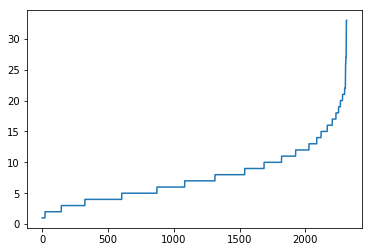

In [12]:
plt.plot(range(len(ll)), sorted(ll))
plt.show()

In [52]:
maxSentLen = 15

In [53]:
weD = 200
wvD = weD

In [54]:
def train(data, label):
    inputs = keras.layers.Input(shape=(maxSentLen, wvD, 1))
    #print(inputs.shape)

    #layer<num>_<filtersize>
    conv_layer1_2 = keras.layers.Conv2D(200, (3, wvD), 1, padding='valid', activation=tf.nn.relu)(inputs)
    #print(conv_layer1_2.shape)
    pool_layer1_2 = keras.layers.MaxPool2D((maxSentLen-3+1, 1), strides=1, padding="valid")(conv_layer1_2)
    #print(pool_layer1_2.shape)

    conv_layer1_3 = keras.layers.Conv2D(200, (4, wvD), 1, padding='valid', activation=tf.nn.relu)(inputs)
    #print(conv_layer1_3.shape)
    pool_layer1_3 = keras.layers.MaxPool2D((maxSentLen-4+1, 1), strides=1, padding="valid")(conv_layer1_3)
    #print(pool_layer1_3.shape)

    conv_layer1_4 = keras.layers.Conv2D(200, (5, wvD), 1, padding='valid', activation=tf.nn.relu)(inputs)
    #print(conv_layer1_4.shape)
    pool_layer1_4 = keras.layers.MaxPool2D((maxSentLen-5+1, 1), strides=1, padding="valid")(conv_layer1_4)
    #print(pool_layer1_4.shape)

    layer1 = keras.layers.concatenate([pool_layer1_2, pool_layer1_3, pool_layer1_4], axis=1)
    #print(layer1.shape)
    layer1 = keras.layers.Flatten()(layer1)
    #print(layer1.shape)
    
    dropout = keras.layers.Dropout(0.5)(layer1)
    
    out = keras.layers.Dense(3, activation=tf.nn.softmax, kernel_regularizer=keras.regularizers.l2(0.01))(dropout)
    #print(out.shape)

    nnModel = keras.models.Model(inputs=inputs, outputs=out)
    nnModel.compile(optimizer=tf.train.AdamOptimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
    #data = np.array([[word2vec['computer'].reshape(300, 1), word2vec['good'].reshape(300, 1), word2vec['screen'].reshape(300, 1), word2vec['bad'].reshape(300, 1), word2vec['keyboard'].reshape(300, 1)]])
    #print("data=", data.shape)
    #label = np.array([[1.0, 0.0, 0.0]])
    #print("label=", label.shape)
    nnModel.fit(data, label, epochs=5)
    return nnModel

In [62]:
X1 = []
y = []
yForSk = []
flag = "attention"

In [63]:
for iii, data in enumerate(dataset):
    data1 = []
    meanAspVec = None
    
    #if more than one word in aspect term, take mean
    #mean = np.zeros((weD, 1))
    for w in data[2]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        meanAspVec = twv
    #print(iii, "---" ,data[2])
#     try:
#         print(word2vec[data[2]].shape)
#     except KeyError:
#         print("KeyError---###################", iii)
    #meanAspVec = word2vec[data[2]].reshape(weD, 1)#mean/len(data[2])
    
    E = []
    
#     for wv in data1:
#         E.append(np.dot(wv.T, meanAspVec)/(np.linalg.norm(wv)) * np.linalg.norm(meanAspVec))
    
#     E = np.array(E).reshape(300, 1)
#     A = np.exp(E) / np.sum(np.exp(E))

    for w in data[1]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        E.append(np.dot(twv.T, meanAspVec) / (np.linalg.norm(twv) * np.linalg.norm(meanAspVec)))

    A = np.exp(E) / np.sum(np.exp(E)) # softmax

    for i, w in enumerate(data[1]):
        twv = None
        if w in missingVectors:
            twv = missingVectors[w]
        else:
            twv = word2vec[w].reshape(weD, 1)
        if flag == "attention":
            data1.append(A[i] * twv)
        elif flag == "input":
            data1.append(twv)

#     for w in data[1]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(300, 1)
#         except KeyError:
#             twv = np.random.normal(size=(300, 1))/math.sqrt(301)
#             missingVectors[w] = twv
            
#         data1.append(np.vstack((twv, meanAspVec)))
    
    if len(data1) < maxSentLen:
        j = len(data1) + 1
        while j <= maxSentLen:
            #data1.append(np.vstack((word2vec['#'].reshape(300, 1), meanAspVec)))
            #data1.append(np.vstack((np.zeros((300, 1)), meanAspVec)))
            data1.append(np.zeros((wvD, 1)))
            j += 1
    
    if len(data1) > maxSentLen:
        del data1[maxSentLen:]
    
    X1.append(np.array(data1))
    yForSk.append(data[-1])
    if data[-1] == '-1':
        y.append(np.array([[0.0, 0.0, 1.0]]))
    elif data[-1] == '0':
        y.append(np.array([[0.0, 1.0, 0.0]]))
    elif data[-1] == '1':
        y.append(np.array([[1.0, 0.0, 0.0]]))

X1 = np.array(X1)
y = np.array(y)

In [64]:
X1.shape

(3602, 15, 200, 1)

In [58]:
y.shape

(3602, 1, 3)

In [59]:
np.shape(yForSk)

(3602,)

In [60]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [65]:
accuracies = []
precisions = []
recalls = []
f1s = []

for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
    print("Fold -", index)
    xtrain, xtest = X1[train_ind], X1[test_ind]
    ytrain, ytest = y[train_ind], y[test_ind]
    
    model = train(xtrain, ytrain)
    
    predictions = model.predict(xtest)
    
    y_pred = tf.argmax(predictions, dimension=1)
    y_test = tf.argmax(ytest.reshape(len(ytest), 3), dimension=1)
    
    print("Labels=", np.unique(y_test, return_counts=True))
    print("Predictions=", np.unique(y_pred, return_counts=True))
    
    cm = confusion_matrix(y_test, y_pred)
    numer = np.diag(cm)
    numer = numer.astype(np.float64)
    deno = np.sum(cm, axis = 1, dtype=np.float64)
    recall = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
    deno = np.sum(cm, axis = 0, dtype=np.float64)
    precision = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
    #loss, acc = model.evaluate(xtest, ytest)
    nnum = (precision*recall)
    ddeno = (precision+recall)
    f1 = 2*np.divide(nnum, ddeno, out=np.zeros_like(nnum), where=ddeno!=0)
    acc = np.sum(numer)/np.sum(deno)
    
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print("accuracy=", acc, "precision=", precision, "recall=", recall, "F1 Score=", f1)


Fold - 0
Epoch 1/5
102/102 [==============================] - 5s 50ms/step - loss: 10.3488 - acc: 0.5978
Epoch 2/5
102/102 [==============================] - 5s 45ms/step - loss: 10.1661 - acc: 0.5993
Epoch 3/5
102/102 [==============================] - 5s 45ms/step - loss: 10.1031 - acc: 0.5993
Epoch 4/5
102/102 [==============================] - 5s 47ms/step - loss: 10.0920 - acc: 0.5993
Epoch 5/5
102/102 [==============================] - 5s 49ms/step - loss: 10.0897 - acc: 0.5993
Labels= (array([0, 1, 2], dtype=int64), array([217,  64,  81], dtype=int64))
Predictions= (array([0], dtype=int64), array([362], dtype=int64))
accuracy= 0.5994475138121547 precision= [0.59944751 0.         0.        ] recall= [1. 0. 0.] F1 Score= [0.74956822 0.         0.        ]
Fold - 1
Epoch 1/5
102/102 [==============================] - 5s 46ms/step - loss: 10.3233 - acc: 0.5959
Epoch 2/5
102/102 [==============================] - 4s 44ms/step - loss: 10.1747 - acc: 0.5993
Epoch 3/5
102/102 [=========

KeyboardInterrupt: 

In [45]:
print("Average Scores:")
print("Avg. accuracy=", np.sum(accuracies)/len(accuracies))
print("Avg. precision=", np.sum(precisions, axis=0)/len(precisions))
print("Avg. recall=", np.sum(recalls, axis=0)/len(recalls))
print("Avg. f1=", np.sum(f1s, axis=0)/len(f1s))

Average Scores:
Avg. accuracy= 0.4267177125722853
Avg. precision= [0.42671771 0.         0.        ]
Avg. recall= [1. 0. 0.]
Avg. f1= [0.59818068 0.         0.        ]


In [ ]:
#cm

In [ ]:
#pred = tf.one_hot(tf.argmax(predictions, dimension=1), depth=3)

In [ ]:
dataset[475]

In [ ]:
#word2vec['#']#.reshape(300, 1) #numpy array
#print(word2vec.similarity('computer', 'laptop'))
#np.zeros(300).shape
#word2vec.distances(word2vec['computer'], other_words=["laptop"])
# a = list('I preferred the fit and feel of the $$ inch.')
# a[a.index(" ", 37, 44)] = "_"
# #a[a.index(" ", 36, 43)] = "_"
# print(''.join(a))
gensim.utils.simple_preprocess('built_in')